# 💼 Financial & Revenue Intelligence Analysis
### Dataset: Brazilian E-Commerce (Olist) | Source: Kaggle

This project analyzes real e-commerce transaction data to extract business intelligence:

- 📈 Revenue trend analysis (monthly)
- 🔁 Repeat vs One-Time customer segmentation
- 🔮 Revenue forecasting (Moving Average)
- 💰 Executive KPI summary
- 📦 Profitability insights

**Final output:** Clean CSV files → Streamlit Dashboard → GitHub Portfolio

In this project, we perform end-to-end financial analytics on a multi-table e-commerce dataset to understand revenue growth, customer retention, profitability drivers, and future sales forecasting. The goal is to simulate a real-world Financial Operations Analyst role using transactional data.

In [52]:
from google.colab import files
uploaded = files.upload()


Saving Olist dataset.zip to Olist dataset (1).zip


In [53]:
import zipfile

with zipfile.ZipFile("Olist dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()


In [54]:
import os
os.listdir()


['.config',
 'monthly_revenue.csv',
 'olist_customers_dataset.csv',
 'olist_master_dataset.csv',
 'olist_sellers_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_items_dataset.csv',
 'product_category_name_translation.csv',
 'churn_summary.csv',
 'olist_orders_dataset.csv',
 'olist_geolocation_dataset.csv',
 'streamlit_project_files.zip',
 'olist_order_reviews_dataset.csv',
 'Olist dataset.zip',
 'Olist dataset (1).zip',
 'customer_summary.csv',
 'streamlit_small_files.zip',
 'olist_products_dataset.csv',
 'sample_data']

Import Libraries

In [56]:

# STEP 2: Import all required libraries
# --------------------------------------------------
import pandas as pd        # Data manipulation — reading CSVs, merging, grouping
import numpy as np         # Numerical operations — useful for math, arrays
import matplotlib.pyplot as plt  # Plotting graphs
import warnings
warnings.filterwarnings('ignore')  # Suppress minor warnings for clean output


Load All Required CSV Files

In [57]:
# --------------------------------------------------
# STEP 3: Load the datasets we need for this project
# --------------------------------------------------

# Orders: contains order status, timestamps, customer ID
orders = pd.read_csv("olist_orders_dataset.csv")

# Order Items: contains price, freight (shipping), product per order
order_items = pd.read_csv("olist_order_items_dataset.csv")

# Customers: maps customer_id → customer_unique_id (important for repeat analysis)
customers = pd.read_csv("olist_customers_dataset.csv")

# Payments: payment method, installments, payment value
payments = pd.read_csv("olist_order_payments_dataset.csv")

# Products: product category information
products = pd.read_csv("olist_products_dataset.csv")

# Category name translation (Portuguese → English)
category_translation = pd.read_csv("product_category_name_translation.csv")

print("Orders shape:", orders.shape)
print("Order Items shape:", order_items.shape)
print("Customers shape:", customers.shape)
print("Payments shape:", payments.shape)

Orders shape: (99441, 8)
Order Items shape: (112650, 7)
Customers shape: (99441, 5)
Payments shape: (103886, 5)


Explore the Data

In [58]:
# --------------------------------------------------
# STEP 4A: Understand the orders dataset
# --------------------------------------------------
print("=== ORDERS ===")
print(orders.head(3))         # First 3 rows — see column names and sample values
print("\nColumns:", orders.columns.tolist())
print("\nNulls:\n", orders.isnull().sum())  # Check for missing data

=== ORDERS ===
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
2           2018-09-04 00:00:00  

Columns: ['order_id', 'customer_id', 'ord

Filter Delivered Orders + Fix Dates

In [59]:
# ── Check all status types ─────────────────────────────
print("Order Status counts:")
print(orders['order_status'].value_counts())
print()

# ── Keep only DELIVERED orders ─────────────────────────
# Reason: cancelled/shipped orders haven't completed revenue
orders_delivered = orders[orders['order_status'] == 'delivered'].copy()

print(f"Before filter : {len(orders):,} orders")
print(f"After filter  : {len(orders_delivered):,} delivered orders")
print()

# ── Convert timestamp columns to datetime ─────────────
# They load as plain strings — must convert to use .dt.year/.dt.month
orders_delivered['order_purchase_timestamp'] = pd.to_datetime(
    orders_delivered['order_purchase_timestamp']
)
orders_delivered['order_delivered_customer_date'] = pd.to_datetime(
    orders_delivered['order_delivered_customer_date']
)

print("Date dtype:", orders_delivered['order_purchase_timestamp'].dtype)
# Should show: datetime64[ns]

print("Date range:",
      orders_delivered['order_purchase_timestamp'].min(),
      "→",
      orders_delivered['order_purchase_timestamp'].max())

Order Status counts:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Before filter : 99,441 orders
After filter  : 96,478 delivered orders

Date dtype: datetime64[ns]
Date range: 2016-09-15 12:16:38 → 2018-08-29 15:00:37


Create Revenue Column

In [60]:
# Revenue = price customer paid + shipping they paid
# Both columns are already in order_items

order_items['revenue'] = order_items['price'] + order_items['freight_value']

print("Sample revenue rows:")
print(order_items[['order_id','price','freight_value','revenue']].head(5))
print()
print("Revenue stats:")
print(order_items['revenue'].describe().round(2))

Sample revenue rows:
                           order_id   price  freight_value  revenue
0  00010242fe8c5a6d1ba2dd792cb16214   58.90          13.29    72.19
1  00018f77f2f0320c557190d7a144bdd3  239.90          19.93   259.83
2  000229ec398224ef6ca0657da4fc703e  199.00          17.87   216.87
3  00024acbcdf0a6daa1e931b038114c75   12.99          12.79    25.78
4  00042b26cf59d7ce69dfabb4e55b4fd9  199.90          18.14   218.04

Revenue stats:
count    112650.00
mean        140.64
std         190.72
min           6.08
25%          55.22
50%          92.32
75%         157.94
max        6929.31
Name: revenue, dtype: float64


Build Master DataFrame

In [61]:
# ── Merge 1: orders + order_items (on order_id) ───────
master_df = pd.merge(
    orders_delivered,   # only delivered orders
    order_items,        # has price, freight, revenue
    on='order_id',
    how='inner'         # only rows that exist in both
)
print("After orders + items merge:", master_df.shape)

# ── Merge 2: add customer_unique_id ───────────────────
# IMPORTANT: customer_id changes every order
# customer_unique_id is the REAL permanent person ID
master_df = pd.merge(
    master_df,
    customers[['customer_id','customer_unique_id']],
    on='customer_id',
    how='left'
)
print("After customer merge:", master_df.shape)

# ── Merge 3: add product category ─────────────────────
master_df = pd.merge(
    master_df,
    products[['product_id','product_category_name']],
    on='product_id',
    how='left'
)

# Translate category names from Portuguese → English
master_df = pd.merge(
    master_df,
    category_translation,
    on='product_category_name',
    how='left'
)

# Use English name, fall back to Portuguese if translation missing
master_df['category'] = master_df['product_category_name_english'].fillna(
    master_df['product_category_name']
)

print("After category merge:", master_df.shape)
print()
print("Master DF columns:")
print(master_df.columns.tolist())

After orders + items merge: (110197, 15)
After customer merge: (110197, 16)
After category merge: (110197, 19)

Master DF columns:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'revenue', 'customer_unique_id', 'product_category_name', 'product_category_name_english', 'category']


Add Time Columns

In [62]:
master_df['year']  = master_df['order_purchase_timestamp'].dt.year
master_df['month'] = master_df['order_purchase_timestamp'].dt.month

print("Year distribution:")
print(master_df['year'].value_counts().sort_index())
print()
print("Sample:")
print(master_df[['order_purchase_timestamp','year','month']].head(3))

Year distribution:
year
2016      317
2017    49556
2018    60324
Name: count, dtype: int64

Sample:
  order_purchase_timestamp  year  month
0      2017-10-02 10:56:33  2017     10
1      2018-07-24 20:41:37  2018      7
2      2018-08-08 08:38:49  2018      8


Monthly Revenue

In [63]:
# ── Aggregate revenue by year + month ─────────────────
# NEVER group by month alone — Jan 2017 and Jan 2018 would merge!
monthly_revenue = (
    master_df
    .groupby(['year','month'])['revenue']
    .sum()
    .reset_index()
)

# Build a proper date column (1st of each month)
monthly_revenue['date'] = pd.to_datetime(
    monthly_revenue['year'].astype(str) + '-' +
    monthly_revenue['month'].astype(str).str.zfill(2) + '-01'
    # zfill(2) pads single digits: "1" → "01" so dates parse correctly
)

monthly_revenue = (
    monthly_revenue[['date','revenue']]
    .sort_values('date')
    .reset_index(drop=True)
)

print(monthly_revenue.to_string())
print(f"\nTotal months of data: {len(monthly_revenue)}")
print(f"Peak month: {monthly_revenue.loc[monthly_revenue['revenue'].idxmax(), 'date'].strftime('%Y-%m')}")
print(f"Peak revenue: BRL {monthly_revenue['revenue'].max():,.2f}")

         date     revenue
0  2016-09-01      143.46
1  2016-10-01    46490.66
2  2016-12-01       19.62
3  2017-01-01   127482.37
4  2017-02-01   271239.32
5  2017-03-01   414330.95
6  2017-04-01   390812.40
7  2017-05-01   566851.40
8  2017-06-01   490050.37
9  2017-07-01   566299.08
10 2017-08-01   645832.36
11 2017-09-01   701077.49
12 2017-10-01   751117.01
13 2017-11-01  1153364.20
14 2017-12-01   843078.29
15 2018-01-01  1077887.46
16 2018-02-01   966168.41
17 2018-03-01  1120598.24
18 2018-04-01  1132878.93
19 2018-05-01  1128774.52
20 2018-06-01  1011978.29
21 2018-07-01  1027807.28
22 2018-08-01   985491.64

Total months of data: 23
Peak month: 2017-11
Peak revenue: BRL 1,153,364.20


Revenue Trend Chart

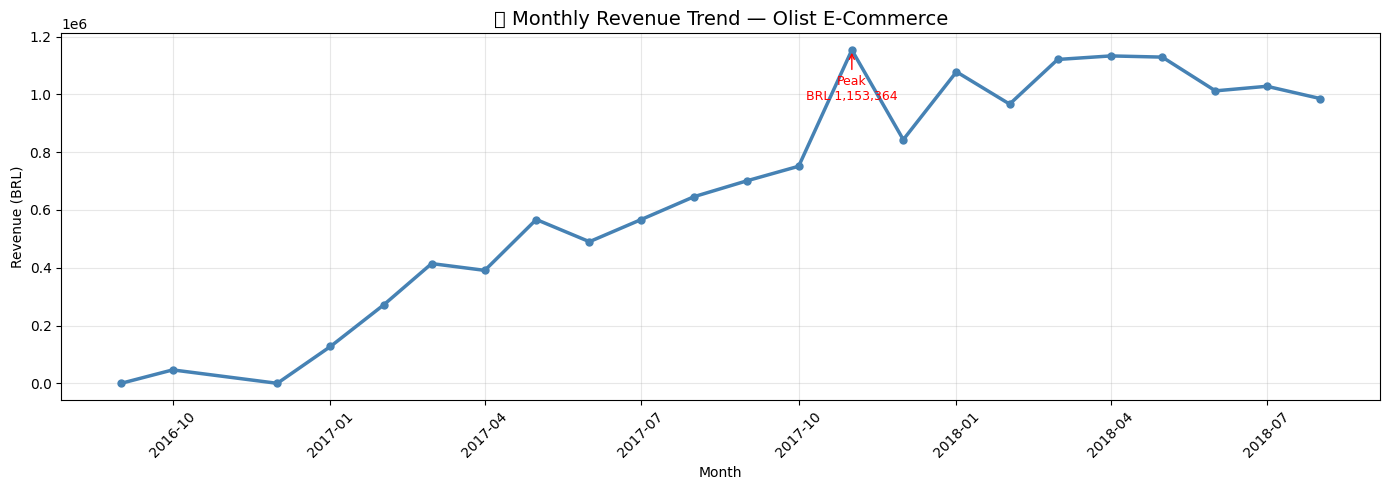

In [64]:
fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(monthly_revenue['date'], monthly_revenue['revenue'],
        marker='o', linewidth=2.5, color='steelblue', markersize=5)

# Highlight peak month
peak_idx = monthly_revenue['revenue'].idxmax()
peak_date = monthly_revenue.loc[peak_idx, 'date']
peak_val  = monthly_revenue.loc[peak_idx, 'revenue']

ax.annotate(f"Peak\nBRL {peak_val:,.0f}",
            xy=(peak_date, peak_val),
            xytext=(peak_date, peak_val * 0.85),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=9, color='red', ha='center')

ax.set_title("📈 Monthly Revenue Trend — Olist E-Commerce", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Revenue (BRL)")
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Repeat vs One-Time Customers

In [65]:
# ── Count distinct orders per unique customer ──────────
customer_orders = (
    master_df
    .groupby('customer_unique_id')['order_id']
    .nunique()   # count of distinct orders — not rows (one order can have many items)
    .reset_index()
)
customer_orders.columns = ['customer_unique_id', 'order_count']

print("Order count distribution (top 10):")
print(customer_orders['order_count'].value_counts().head(10))
print()

# ── Classify ───────────────────────────────────────────
repeat_customers  = (customer_orders['order_count'] > 1).sum()
one_time_customers = (customer_orders['order_count'] == 1).sum()
total_customers   = len(customer_orders)

repeat_pct   = (repeat_customers / total_customers) * 100
one_time_pct = (one_time_customers / total_customers) * 100

print(f"🔁 Repeat Customers   : {repeat_customers:,}  ({repeat_pct:.1f}%)")
print(f"👤 One-Time Customers : {one_time_customers:,}  ({one_time_pct:.1f}%)")
print(f"📊 Total Customers    : {total_customers:,}")

Order count distribution (top 10):
order_count
1     90557
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: count, dtype: int64

🔁 Repeat Customers   : 2,801  (3.0%)
👤 One-Time Customers : 90,557  (97.0%)
📊 Total Customers    : 93,358


Revenue contribution per customer type

In [66]:
# ── Revenue contribution per customer type ────────────
customer_orders['customer_type'] = customer_orders['order_count'].apply(
    lambda x: 'Repeat' if x > 1 else 'One-Time'
)

master_df = pd.merge(
    master_df,
    customer_orders[['customer_unique_id','customer_type']],
    on='customer_unique_id',
    how='left'
)

revenue_by_type = (
    master_df.groupby('customer_type')['revenue']
    .sum()
    .reset_index()
)
revenue_by_type['pct'] = (revenue_by_type['revenue'] / revenue_by_type['revenue'].sum() * 100).round(1)

print("\nRevenue by Customer Type:")
print(revenue_by_type)


Revenue by Customer Type:
  customer_type      revenue   pct
0      One-Time  14555586.29  94.4
1        Repeat    864187.46   5.6


Visualize

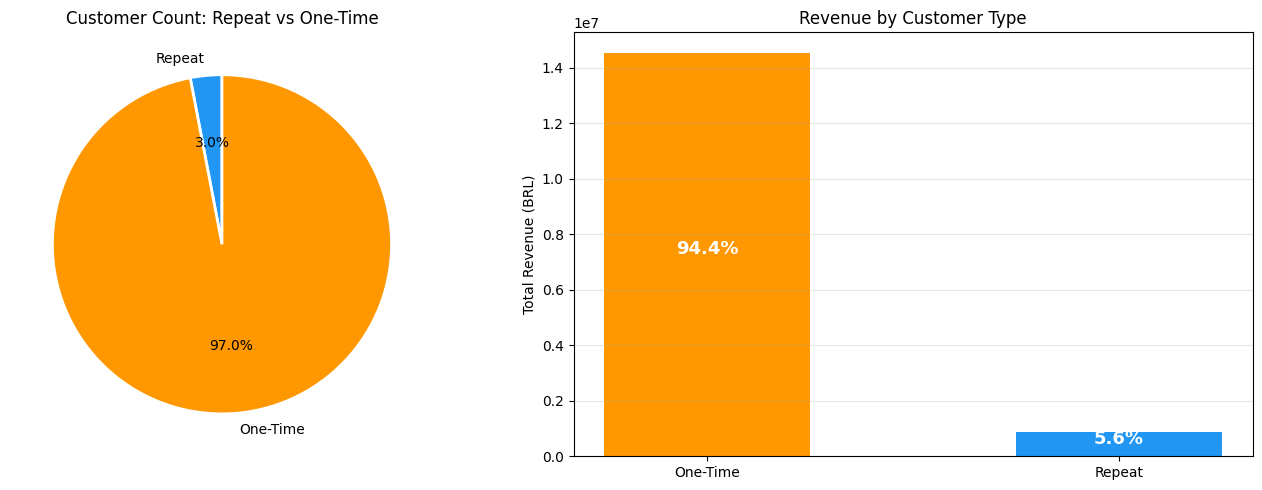

In [67]:
# ── Visualize ──────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: pie chart — count
axes[0].pie(
    [repeat_customers, one_time_customers],
    labels=['Repeat', 'One-Time'],
    autopct='%1.1f%%',
    colors=['#2196F3','#FF9800'],
    startangle=90,
    wedgeprops={'edgecolor':'white','linewidth':2}
)
axes[0].set_title("Customer Count: Repeat vs One-Time", fontsize=12)

# Right: bar chart — revenue
colors = ['#2196F3' if t == 'Repeat' else '#FF9800'
          for t in revenue_by_type['customer_type']]
bars = axes[1].bar(revenue_by_type['customer_type'],
                   revenue_by_type['revenue'], color=colors, width=0.5)
axes[1].set_title("Revenue by Customer Type", fontsize=12)
axes[1].set_ylabel("Total Revenue (BRL)")
axes[1].grid(axis='y', alpha=0.3)

for bar, (_, row) in zip(bars, revenue_by_type.iterrows()):
    axes[1].text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() * 0.5,
                 f"{row['pct']}%",
                 ha='center', color='white', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

Revenue Forecast

In [68]:
# ── Build forecast ─────────────────────────────────────
monthly_series = monthly_revenue.set_index('date')['revenue']

ma_3 = monthly_series.rolling(window=3).mean()  # reacts fast to changes
ma_6 = monthly_series.rolling(window=6).mean()  # shows longer-term trend

# Forecast = average of last 3 months extended 3 months forward
last_3_avg = monthly_series.tail(3).mean()
last_date  = monthly_series.index[-1]

future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    periods=3,
    freq='MS'   # MS = Month Start
)
forecast_series = pd.Series([last_3_avg] * 3, index=future_dates)

print("📅 3-Month Revenue Forecast:")
for date, val in forecast_series.items():
    print(f"   {date.strftime('%Y-%m')} → BRL {val:,.2f}")

📅 3-Month Revenue Forecast:
   2018-09 → BRL 1,008,425.74
   2018-10 → BRL 1,008,425.74
   2018-11 → BRL 1,008,425.74


Plot

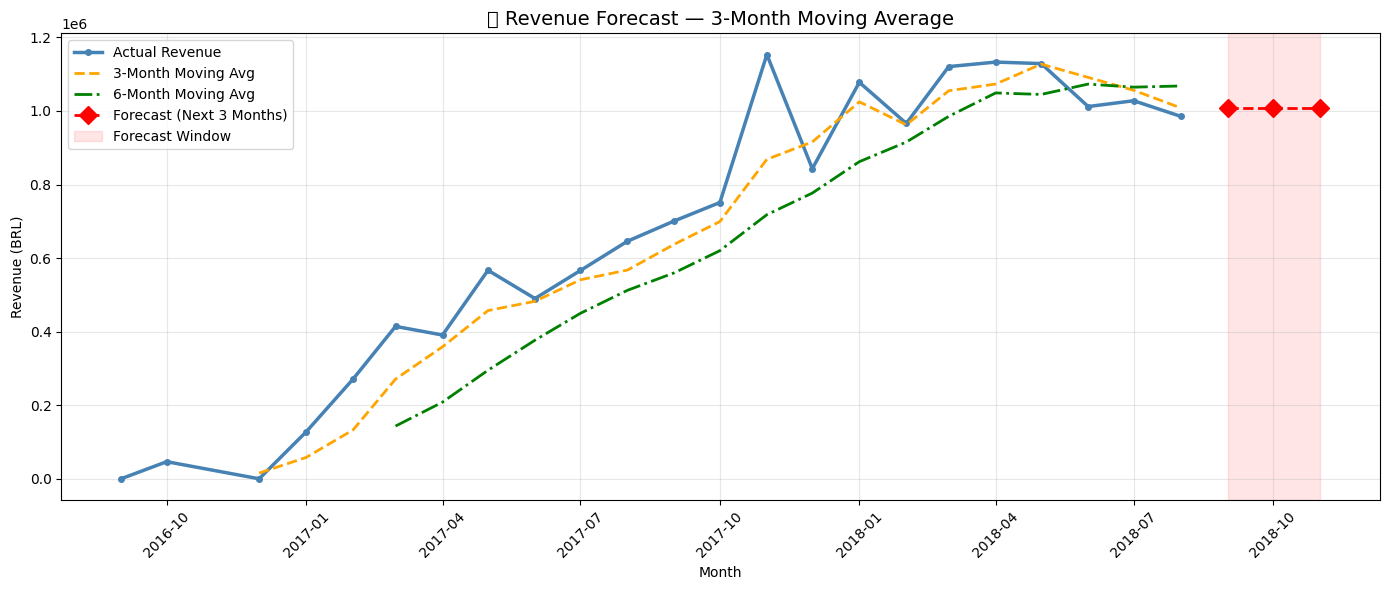

In [69]:
# ── Plot ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(monthly_series.index, monthly_series.values,
        label='Actual Revenue', color='steelblue', linewidth=2.5, marker='o', markersize=4)

ax.plot(ma_3.index, ma_3.values,
        label='3-Month Moving Avg', color='orange', linewidth=2, linestyle='--')

ax.plot(ma_6.index, ma_6.values,
        label='6-Month Moving Avg', color='green', linewidth=2, linestyle='-.')

ax.plot(forecast_series.index, forecast_series.values,
        label='Forecast (Next 3 Months)', color='red',
        linewidth=2, linestyle='--', marker='D', markersize=9)

ax.axvspan(forecast_series.index[0], forecast_series.index[-1],
           alpha=0.1, color='red', label='Forecast Window')

ax.set_title("🔮 Revenue Forecast — 3-Month Moving Average", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Revenue (BRL)")
ax.legend(loc='upper left')
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Top Categories by Revenue

Top 10 Revenue Categories:
             category    revenue
        health_beauty 1412089.53
        watches_gifts 1264333.12
       bed_bath_table 1225209.26
       sports_leisure 1118256.91
computers_accessories 1032723.77
      furniture_decor  880329.92
           housewares  758392.25
           cool_stuff  691680.89
                 auto  669454.75
         garden_tools  567145.68


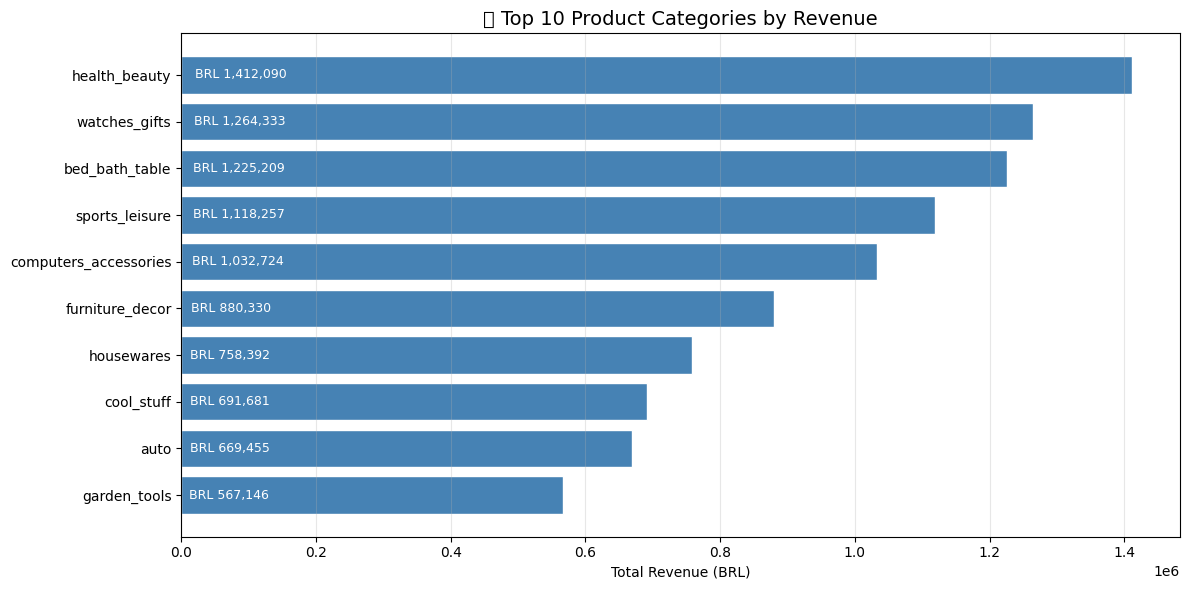

In [70]:
category_revenue = (
    master_df.groupby('category')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

print("Top 10 Revenue Categories:")
print(category_revenue.to_string(index=False))

# ── Plot ───────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))

ax.barh(category_revenue['category'][::-1],
        category_revenue['revenue'][::-1],
        color='steelblue', edgecolor='white')

ax.set_title("💰 Top 10 Product Categories by Revenue", fontsize=14)
ax.set_xlabel("Total Revenue (BRL)")
ax.grid(axis='x', alpha=0.3)

for i, (val, cat) in enumerate(zip(
        category_revenue['revenue'][::-1],
        category_revenue['category'][::-1])):
    ax.text(val * 0.01, i, f" BRL {val:,.0f}", va='center', fontsize=9, color='white')

plt.tight_layout()
plt.show()

Executive KPI Summary

In [71]:
total_revenue    = master_df['revenue'].sum()
total_orders     = master_df['order_id'].nunique()
total_customers  = master_df['customer_unique_id'].nunique()

# Average order value = group to order level FIRST, then average
# (don't average item-level rows — that's avg item value, not avg order value)
avg_order_value  = master_df.groupby('order_id')['revenue'].sum().mean()

# Month-over-month revenue growth
last_rev = monthly_revenue.iloc[-1]['revenue']
prev_rev = monthly_revenue.iloc[-2]['revenue']
mom_growth = ((last_rev - prev_rev) / prev_rev) * 100

print("=" * 52)
print("         📊 EXECUTIVE KPI SUMMARY")
print("=" * 52)
print(f"  💰  Total Revenue          : BRL {total_revenue:>13,.2f}")
print(f"  📦  Total Orders           : {total_orders:>16,}")
print(f"  👥  Unique Customers       : {total_customers:>16,}")
print(f"  🛒  Avg Order Value        : BRL {avg_order_value:>13,.2f}")
print(f"  🔁  Repeat Customer Rate   : {repeat_pct:>15.1f}%")
print(f"  📈  MoM Revenue Growth     : {mom_growth:>15.1f}%")
print("=" * 52)

         📊 EXECUTIVE KPI SUMMARY
  💰  Total Revenue          : BRL 15,419,773.75
  📦  Total Orders           :           96,478
  👥  Unique Customers       :           93,358
  🛒  Avg Order Value        : BRL        159.83
  🔁  Repeat Customer Rate   :             3.0%
  📈  MoM Revenue Growth     :            -4.1%


Save All CSVs

In [72]:
# ── monthly_revenue.csv ───────────────────────────────
monthly_revenue.to_csv("monthly_revenue.csv", index=False)

# ── customer_revenue.csv ──────────────────────────────
customer_revenue = (
    master_df.groupby('customer_unique_id')['revenue']
    .sum()
    .reset_index()
    .sort_values('revenue', ascending=False)
    .reset_index(drop=True)
)
customer_revenue.to_csv("customer_revenue.csv", index=False)

# ── customer_repeat.csv ───────────────────────────────
repeat_df = pd.DataFrame({
    'Type'       : ['Repeat', 'One-Time'],
    'Count'      : [repeat_customers, one_time_customers],
    'Percentage' : [round(repeat_pct, 1), round(one_time_pct, 1)]
})
repeat_df.to_csv("customer_repeat.csv", index=False)

# ── category_revenue.csv ──────────────────────────────
category_revenue.to_csv("category_revenue.csv", index=False)

# ── kpi_summary.csv ───────────────────────────────────
kpi_df = pd.DataFrame({
    'Metric': ['Total Revenue','Total Orders','Unique Customers',
               'Avg Order Value','Repeat Customer Rate %','MoM Growth %'],
    'Value' : [round(total_revenue,2), total_orders, total_customers,
               round(avg_order_value,2), round(repeat_pct,2), round(mom_growth,2)]
})
kpi_df.to_csv("kpi_summary.csv", index=False)

print("✅ All 5 CSV files saved")
print()
for f in ["monthly_revenue.csv","customer_revenue.csv","customer_repeat.csv",
          "category_revenue.csv","kpi_summary.csv"]:
    df_check = pd.read_csv(f)
    print(f"  {f:35s} → {df_check.shape}")

✅ All 5 CSV files saved

  monthly_revenue.csv                 → (23, 2)
  customer_revenue.csv                → (93358, 2)
  customer_repeat.csv                 → (2, 3)
  category_revenue.csv                → (10, 2)
  kpi_summary.csv                     → (6, 2)


In [73]:
# ── Download all files ────────────────────────────────
from google.colab import files

for f in ["monthly_revenue.csv","customer_revenue.csv","customer_repeat.csv",
          "category_revenue.csv","kpi_summary.csv"]:
    files.download(f)
    print(f"⬇️  {f}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  monthly_revenue.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  customer_revenue.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  customer_repeat.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  category_revenue.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️  kpi_summary.csv
